## Chapter 8 – Dimensionality Reduction

### Setup

First, let's import a few common modules

In [1]:
# Common imports
import numpy as np
import sklearn
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import warnings
warnings.filterwarnings("ignore")

Two uses of Dimensionality reduction
 - Fixes curse of dimensionality by identifying top features.
 - Data visualization by plotting on reduced dimensions.
 
Techniques:
 - **PCA** - Principal Component Analysis
 - **Kernel PCA** - Extension of PCA 
 - **LLE** - Locally-Linear Embedding
 - Other Dimensionality Reduction Techniques with `Scikit-Learn`
     - **t-SNE** - t-distributed Stochastic Neighbor Embedding 
     - **MDS**
     - **Isomap**


Things behave very differently in high-dimensional space. For example, 
 - Random point in a `1 × 1` square, will have only about a 0.4% chance of being located less than 0.001 from a border.
 - But in a `10,000`-dimensional unit hypercube,this probability is greater than `99.999999%`. Most points in a high-dimensional hypercube are very close to the border.

Here is a more troublesome difference: 
 - The average distance between two random points in a unit square will be roughly `0.52`.  
 - Two random points in a unit 3D cube, the average distance will be roughly `0.66`.
 - Two points picked randomly in a `1,000,000`-dimensional hypercube, the average distance, believe it or not, will be about $\sqrt{1,000,000/6} \approx$ `408.25`

How can two points be so far apart when they both lie within the same unit hypercube? 

This implies that **highdimensional datasets are at risk of being very sparse**: most training instances are likely to be far away from each other. Of course, this also means that a new instance will likely be far away from any training instance, making predictions much less reliable than in lower dimensions, since they will be based on much larger extrapolations.

In short, the more dimensions the training set has, the greater the **risk of overfitting it**.

Another solution to the curse of dimensionality is to **increase the size of the training set** to reach a sufficient density of training instances. Unfortunately, in practice, the number of training instances required to reach a given density grows exponentially with the number of dimensions. With just 100 features you would need training instances more than the number of atoms in the observable universe in order for the training instances to be within `0.1` of each other on average, assuming they were spread out uniformly across all dimensions.

## PCA

For an $m \times n$ matrix, PCA gives a decomposition of the form $X=USV^T$, where,
 - $U$ is the  $m \times m$ matrix containing the orthonormal eigenvectors of $X^TX$
 - $V$ is the  $n \times n$ matrix containing the orthonormal eigenvectors of $XX^T$ and 
 - $S$ is the $m \times m$ diagonal matrix containing eigenvalues of $X^TX$.


Since $UU^TX = USV^T = XVV^T$, we can use either the left eigenspace or the right eigenspace to reduce demension:
 - Left eigenspace - `U.T[:,:r] @ X` reduces $m$ to $r$  and `U[:,:r] @ U.T[:,:r] @ X` reconstructs.
 - Right eigenspace - `X @ V[:,:r]` reduces $n$ to $r$ and `X @ V[:,:r] @ V.T[:,:r]` reconstructs.

Let's build a simple 3D dataset:

In [2]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

print(X.shape)

(60, 3)


## Principal Components

In [3]:
X_centered = X - X.mean(axis=0)
m, n = X_centered.shape

U, s, Vt = np.linalg.svd(X_centered)

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

print(U.shape)
print(S.shape)
print(Vt.shape)

(60, 60)
(60, 3)
(3, 3)


In [4]:
s

array([6.77645005, 2.82403671, 0.78116597])

In [5]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

### Projecting down to lower dimensions and reconstruction

In [6]:
W_l = U[:, :2]
X_lp = W_l.T.dot(X_centered)          # projection on to the left eigenspace
X_lr = W_l.dot(W_l.T).dot(X_centered) # reconstruction from the left eigenspace

print(X_lp.shape)
print(X_lr.shape)

(2, 3)
(60, 3)


In [7]:
W_r = Vt.T[:, :2]
X_rp = X_centered.dot(W_r)            # projection on to the right eigenspace
X_rr = X_centered.dot(W_r).dot(W_r.T) # reconstruction from the right eigenspace

print(X_rp.shape)
print(X_rr.shape)

(60, 2)
(60, 3)


By using either eigenspace, you reconstruct the same. i.e. `X_lr = X_rr`

In [8]:
np.allclose(X_lr, X_rr)

True

### Using Scikit-Learn

With `Scikit-Learn`, PCA is really trivial. It even takes care of mean centering for you. As you can see below,
 - `pca.fit_transform(X) = - X_rp`
 - `pca.inverse_transform(X_p) = X_lr = X_rr`

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X_p = pca.fit_transform(X)

Notice that running PCA multiple times on slightly different datasets may result in different results. *In general the only difference is that some axes may be flipped*. 

In this example, PCA using `Scikit-Learn` gives the same projection as the one given by the SVD approach, except both axes are flipped:

In [10]:
np.allclose(X_p, - X_rp)

True

Recover the 3D points projected on the plane (PCA 2D subspace).

In [11]:
X_inv = pca.inverse_transform(X_p)

Of course, there was some loss of information during the projection step, so the recovered 3D points are not exactly equal to the original 3D points:

In [12]:
np.allclose(X_inv, X)

False

We can compute the reconstruction error:

In [13]:
np.mean(np.sum(np.square(X_inv - X), axis=1))

0.010170337792848549

The reconstructions from both methods are not identical because Scikit-Learn's `PCA` class automatically takes care of reversing the mean centering, but if we subtract the mean, we get the same reconstruction:

In [14]:
np.allclose(X_inv - pca.mean_, X_lr)

True

The `PCA` object gives access to the principal components that it computed:

In [15]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

Compare to the first two principal components computed using the SVD method:

In [16]:
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

Notice how the axes are flipped.

### Explained Variance Ratio

Explained variance ratio of each principal component, available via the `explained_variance_ratio_` variable, indicates the proportion of the dataset’s variance that lies along the axis of each principal component.

Now let's look at the explained variance ratio:

In [17]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

The first dimension explains `84.2%` of the variance, while the second explains `14.6%`.

By projecting down to 2D, we lost about 1.1% of the variance:

In [18]:
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

Here is how to compute the explained variance ratio using the SVD approach (recall that `s` is the diagonal of the matrix `S`):
$$\frac{s^2}{sum(s)}$$

In [19]:
np.square(s) / np.square(s).sum()

array([0.84248607, 0.14631839, 0.01119554])

### Choosing the Right Number of Dimensions

In [20]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [21]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

Instead of randomly choosing the number of dimensions to reduce down to, it is generally preferable to choose the number of dimensions that add up to a sufficiently large portion of the variance (e.g., `95%`).

`PCA()` computes PC's without reducing dimensionality and can be used to deside the number of PC's required to preserve 95% of the training set’s variance:

In [22]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [23]:
d

154

You can also specify before hand, the ratio of variance you wish to preserve by setting `n_components = 0.95`

In [24]:
pca = PCA(n_components = 0.95)
X_reduced = pca.fit_transform(X_train)

In [25]:
pca.n_components_

154

In [26]:
np.sum(pca.explained_variance_ratio_)

0.9503684424557429

### Explained variance as a function of the number of dimensions

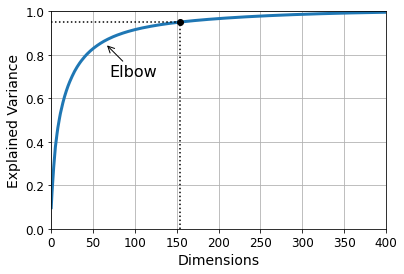

In [27]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)

plt.show()

## PCA for Compression

In [28]:
pca = PCA(n_components=154)
X_reduced_pca = pca.fit_transform(X_train)
X_recovered_pca = pca.inverse_transform(X_reduced_pca)

### MNIST compression that preserves 95% of the variance

In [29]:
# EXTRA
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

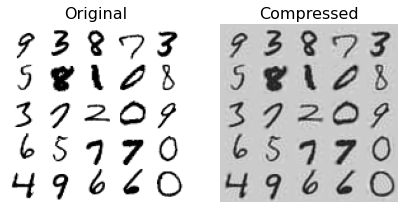

In [30]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)

plt.subplot(122)
plot_digits(X_recovered_pca[::2100])
plt.title("Compressed", fontsize=16)

plt.show()

### Randomized PCA

If you set `svd_solver = "randomized"`, `Scikit-Learn` uses a stochastic algorithm called **Randomized PCA** that quickly finds an approximation of the first $d$ principal components. Its computational complexity is $O(m \times d^2) + O(d^3)$, instead of $O(m \times n^2) + O(n^3)$ for the full SVD approach, so it is dramatically faster than full SVD when d is much smaller than n:

In [31]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced_rand_pca = rnd_pca.fit_transform(X_train)

In [32]:
X_recovered_rand_pca = rnd_pca.inverse_transform(X_reduced_rand_pca)

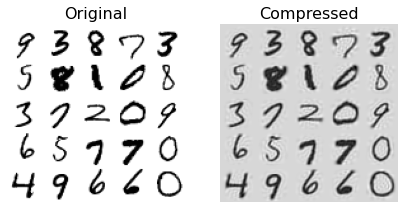

In [33]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)

plt.subplot(122)
plot_digits(X_recovered_rand_pca[::2100])
plt.title("Compressed", fontsize=16)

plt.show()

In [34]:
np.allclose(X_reduced_pca, X_reduced_rand_pca)

False

### Incremental PCA

One problem with the Randomized PCA is that they require the whole training set to fit in memory in order for the algorithm to run. Fortunately, **Incremental PCA (IPCA)** algorithms have been developed: you can split the training set into mini-batches and feed an IPCA algorithm one mini-batch at a time. This is useful for large training sets, and also to apply PCA online.

In [35]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="") 
    inc_pca.partial_fit(X_batch)

X_reduced_inc_pca = inc_pca.transform(X_train)

....................................................................................................

In [36]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced_inc_pca)

Let's check that compression still works well:

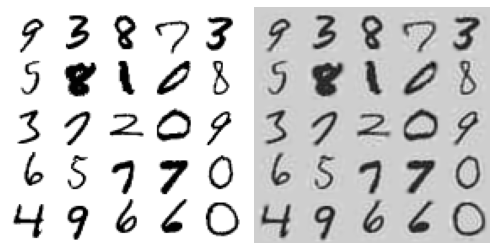

In [37]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])

plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

Let's compare the results of transforming MNIST using regular PCA and incremental PCA. First, the means are equal: 

In [38]:
np.allclose(pca.mean_, inc_pca.mean_)

True

But the results are not exactly identical. Incremental PCA gives a very good approximate solution, but it's not perfect:

In [39]:
np.allclose(X_reduced_pca, X_reduced_inc_pca)

False

### Using `memmap()`:

`NumPy`’s `memmap` class allows you to manipulate a large array stored in a binary file on disk as if it were entirely in memory; the class loads only the data it needs in memory, when it needs it.

Let's create the `memmap()` structure and copy the MNIST data into it. This would typically be done by a first program:

In [40]:
filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

Now deleting the `memmap()` object will trigger its Python finalizer, which ensures that the data is saved to disk.

In [41]:
del X_mm

Next, another program would load the data and use it for training:

In [42]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, n_components=154)

**Time complexity:**

Let's time regular PCA against Incremental PCA and Randomized PCA, for various number of principal components:

In [43]:
import time

for n_components in (2, 10, 154):
    print("n_components =", n_components)
    regular_pca = PCA(n_components=n_components, svd_solver="full")
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver="randomized")

    for name, pca in (("PCA", regular_pca), ("Inc PCA", inc_pca), ("Rnd PCA", rnd_pca)):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print("    {}: {:.1f} seconds".format(name, t2 - t1))

n_components = 2
    PCA: 9.5 seconds
    Inc PCA: 14.8 seconds
    Rnd PCA: 1.6 seconds
n_components = 10
    PCA: 9.2 seconds
    Inc PCA: 14.5 seconds
    Rnd PCA: 2.9 seconds
n_components = 154
    PCA: 9.3 seconds
    Inc PCA: 21.8 seconds
    Rnd PCA: 6.7 seconds


Now let's compare PCA and Randomized PCA for datasets of different sizes (number of instances):

Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

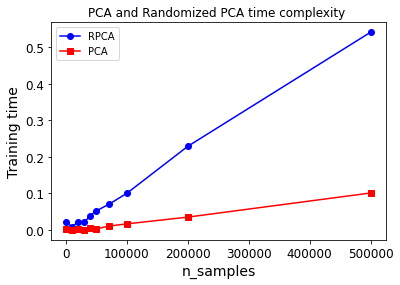

In [44]:
times_rpca = []
times_pca = []
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes:
    X = np.random.randn(n_samples, 5)
    pca = PCA(n_components=2, svd_solver="randomized", random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components=2, svd_solver="full")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

And now let's compare their performance on datasets of 2,000 instances with various numbers of features:

Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

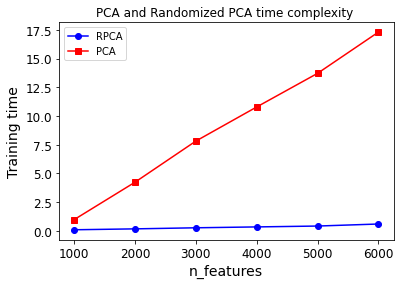

In [45]:
times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes:
    X = np.random.randn(2000, n_features)
    pca = PCA(n_components=2, random_state=42, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components=2, svd_solver="full")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_features")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

# Kernel PCA

In [46]:
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [47]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

### Swiss roll reduced to 2D using kPCA with various kernels

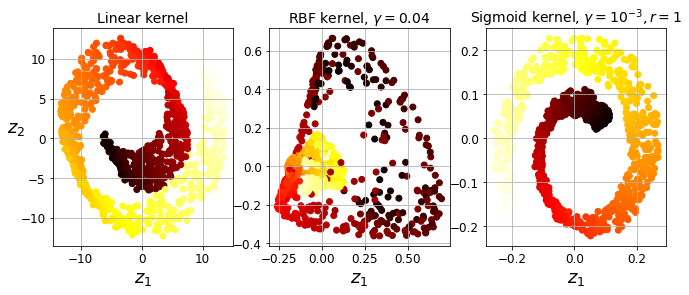

In [48]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

### Kernel PCA and the reconstruction pre-image error

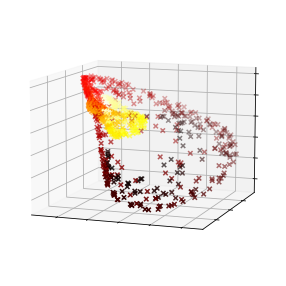

In [49]:
plt.figure(figsize=(6, 5))

X_inverse = rbf_pca.inverse_transform(X_reduced_rbf)

ax = plt.subplot(111, projection='3d')
ax.view_init(10, -70)
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X_inverse[:, 2], c=t, cmap=plt.cm.hot, marker="x")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

plt.show()

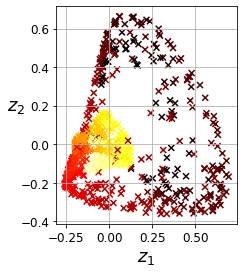

In [50]:
X_reduced = rbf_pca.fit_transform(X)

plt.figure(figsize=(11, 4))
plt.subplot(132)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot, marker="x")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

### Selecting a Kernel and Tuning Hyperparameters

In [51]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [52]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


In [53]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [54]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.7863087957661

## LLE - Locally Linear Embedding

Another very powerful nonlinear dimensionality reduction (NLDR) technique. It is a Manifold Learning technique that does not rely on projections like the previous algorithms. In a nutshell, LLE works by first measuring how each training instance linearly relates to its closest neighbors (c.n.), and then looking for a low-dimensional representation of the training set where these local relationships are best preserved (more details shortly). This makes it particularly good at unrolling twisted manifolds, especially when there is not too much noise.

In [55]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [56]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

**Code to generate Figure 8–12. Unrolled Swiss roll using LLE:**

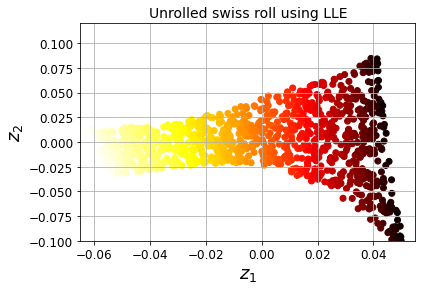

In [57]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

plt.show()

## Other Dimensionality Reduction Techniques

In [58]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

In [59]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [60]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

In [61]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

### Using various techniques to reduce the Swill roll to 2D

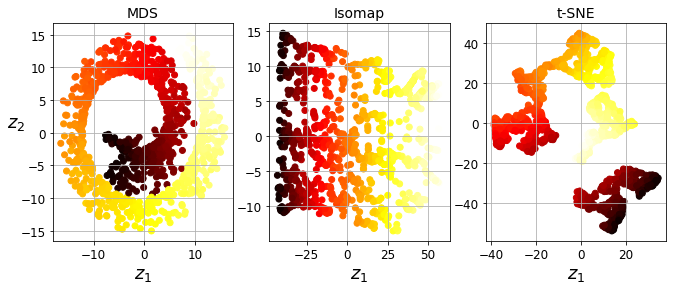

In [62]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()